In [13]:
# from google.colab import drive
# drive.mount('/content/drive')

In [14]:
%cd /content/drive/MyDrive/Modules/FinalYearProject/Implementation

[WinError 3] The system cannot find the path specified: '/content/drive/MyDrive/Modules/FinalYearProject/Implementation'
g:\My Drive\Modules\FinalYearProject\Implementation


C:\Users\Niamat-PC\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\IPython\core\magics\osm.py:393: UserWarning: using bookmarks requires you to install the `pickleshare` library.
  bkms = self.shell.db.get('bookmarks', {})


In [15]:
import os
import time
import soundfile as sf
import librosa
import numpy as np
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision.models import resnet34
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

In [16]:
class AudioDataset(Dataset):
    def __init__(self, file_paths, labels):
        self.file_paths = file_paths
        self.labels = labels

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        audio, sr = sf.read(self.file_paths[idx])
        if len(audio.shape) > 1 and audio.shape[1] == 2:
            audio = np.mean(audio, axis=1)
        audio = librosa.resample(y=audio, orig_sr=sr, target_sr=8000)
        max_length = 5 * 8000
        if len(audio) < max_length:
            audio = np.pad(audio, (0, max_length - len(audio)))
        elif len(audio) > max_length:
            audio = audio[:max_length]
        audio = audio.reshape(1, 1, -1)
        label = self.labels[idx]
        return audio, label

In [17]:
class AudioClassifier(nn.Module):
    def __init__(self):
        super(AudioClassifier, self).__init__()
        if torch.cuda.is_available():
            self.device = torch.device('cuda:0')
        else:
            self.device = torch.device('cpu')
        self.model = resnet34(weights='DEFAULT')
        self.model.fc = nn.Linear(512, 3)
        self.model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        self.model = self.model.to(self.device)

    def forward(self, x):
        x = self.model(x)
        return x

In [18]:
# Generate the list of file paths and labels
root_dir = 'datasets/crowd_audio'
classes = ['high', 'medium', 'low']
file_paths = []
labels = []
for i, cls in enumerate(classes):
    dir_path = os.path.join(root_dir, cls)
    for file_name in os.listdir(dir_path):
        if file_name.endswith('.wav'):
            file_paths.append(os.path.join(dir_path, file_name))
            labels.append(i)

# Split the data into training and testing sets
train_files, test_files, train_labels, test_labels = train_test_split(file_paths, labels, test_size=0.3, random_state=42)

# Create the AudioDataset instances
train_dataset = AudioDataset(train_files, train_labels)
test_dataset = AudioDataset(test_files, test_labels)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [19]:
model = AudioClassifier()


In [20]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())


In [21]:
num_epochs = 5
patience = 5  # Number of epochs to wait before stopping
best_loss = np.inf
stop_counter = 0

# Training loop
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []
for epoch in range(num_epochs):
    start_time = time.time()
    model.train()
    train_correct = 0
    train_total = 0
    for i, (audio, labels) in enumerate(train_dataloader):
        audio = audio.float()
        outputs = model(audio)
        loss = criterion(outputs, labels)
        _, predicted = torch.max(outputs.data, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    train_accuracy = train_correct / train_total
    train_accuracies.append(train_accuracy)
    train_losses.append(loss.item())

    model.eval()
    test_correct = 0
    test_total = 0
    with torch.no_grad():
        for i, (audio, labels) in enumerate(test_dataloader):
            audio = audio.float()
            outputs = model(audio)
            loss = criterion(outputs, labels)
            _, predicted = torch.max(outputs.data, 1)
            test_total += labels.size(0)
            test_correct += (predicted == labels).sum().item()
    test_accuracy = test_correct / test_total
    test_accuracies.append(test_accuracy)
    test_losses.append(loss.item())
    end_time = time.time()

    # Early stopping
    if test_losses[-1] < best_loss:
        best_loss = test_losses[-1]
        stop_counter = 0
    else:
        stop_counter += 1
        if stop_counter >= patience:
            print("Early stopping triggered.")
            break

    print(f'Epoch {epoch+1}/{num_epochs}, Time: {end_time-start_time}s, Train Loss: {train_losses[-1]}, Train Accuracy: {train_accuracies[-1]}, Test Loss: {test_losses[-1]}, Test Accuracy: {test_accuracies[-1]}')


Epoch 1/5, Time: 206.4800763130188s, Train Loss: 0.04631752520799637, Train Accuracy: 0.6891891891891891, Test Loss: 2.041193962097168, Test Accuracy: 0.1875
Epoch 2/5, Time: 188.7761812210083s, Train Loss: 0.00577633548527956, Train Accuracy: 0.9932432432432432, Test Loss: 3.266465663909912, Test Accuracy: 0.46875
Epoch 3/5, Time: 199.29129767417908s, Train Loss: 0.06314827501773834, Train Accuracy: 0.9527027027027027, Test Loss: 1.1411844491958618, Test Accuracy: 0.46875
Epoch 4/5, Time: 191.36536121368408s, Train Loss: 0.06806455552577972, Train Accuracy: 0.972972972972973, Test Loss: 1.5565468072891235, Test Accuracy: 0.46875
Epoch 5/5, Time: 202.396879196167s, Train Loss: 0.004738599993288517, Train Accuracy: 0.9932432432432432, Test Loss: 1.5931960344314575, Test Accuracy: 0.46875


In [22]:
torch.save(model.state_dict(), 'audio_model.pth')


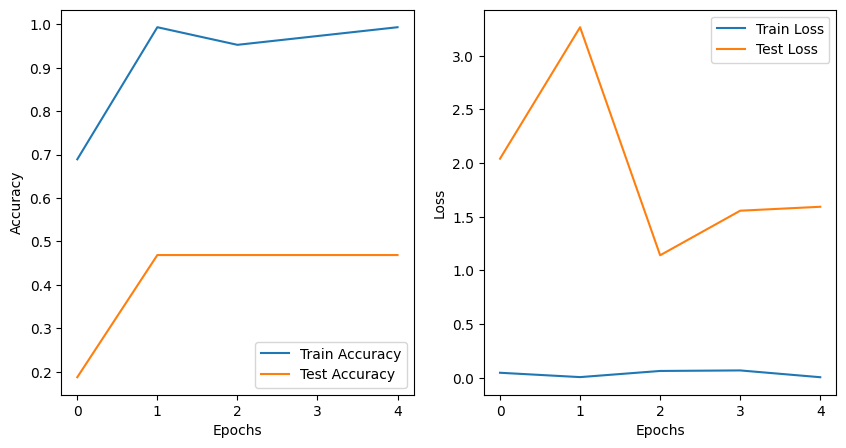

In [23]:
# Plotting the training and testing accuracy
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(range(len(train_accuracies)), train_accuracies, label='Train Accuracy')
plt.plot(range(len(test_accuracies)), test_accuracies, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plotting the training and testing loss
plt.subplot(1, 2, 2)
plt.plot(range(len(train_losses)), train_losses, label='Train Loss')
plt.plot(range(len(test_losses)), test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


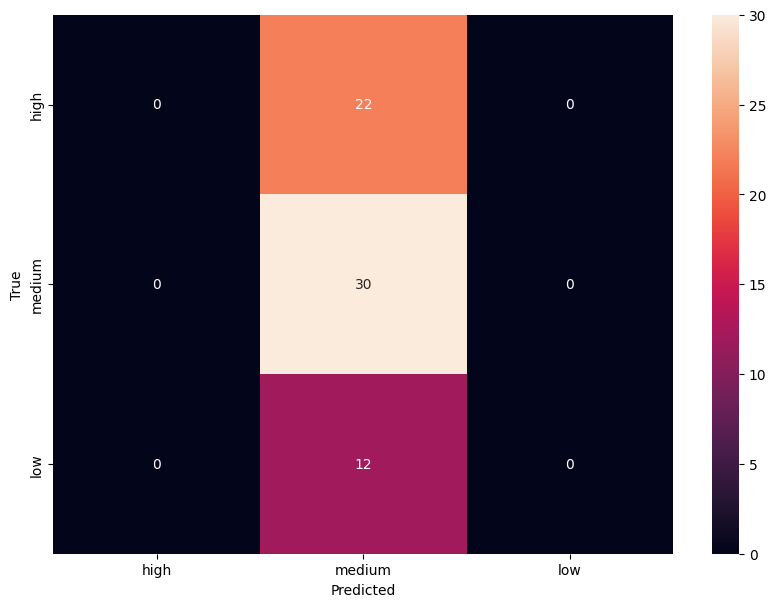

In [24]:
# Confusion matrix
model.eval()
all_labels = []
all_predictions = []
with torch.no_grad():
    for i, (audio, labels) in enumerate(test_dataloader):
        audio = audio.float()
        outputs = model(audio)
        _, predicted = torch.max(outputs.data, 1)
        all_labels.extend(labels)
        all_predictions.extend(predicted)

cm = confusion_matrix(all_labels, all_predictions)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=['high', 'medium', 'low'], yticklabels=['high', 'medium', 'low'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()